# DSC-057 Continuum Source Finding: step 4
---
 Template adapted from SWT-010-T1 for Teal Team's LOFAR Source Finding
### Authors:
Teal Team

### Summary: 
This notebook is a first implementation of DSC-057, Continuum Source Finding: step 4 of https://confluence.skatelescope.org/display/SRCSC/DSC-057+Detailed+breakdown

Ticket: TEAL-1135 https://jira.skatelescope.org/browse/TEAL-1135

**Dependencies:**  `numpy`, `astropy`, `pybdsf`
 
**Last updated: 2025-10-21**

# PyBDSF-based Radio Source Detection for LOFAR-like FITS Images

This notebook provides an interactive version of the PyBDSF source detection pipeline for LOFAR-like FITS images.

## Features

1. **FITS header inspection** - prints key WCS/beam information
2. **Background mean / RMS noise map estimation** via PyBDSF
3. **Island detection and Gaussian fitting**
4. **Source & Gaussian catalog export** (FITS format)
5. **Overlay plot** of detected source positions on the input image
6. **3D cube handling** - select a plane or collapse along spectral axis

## Usage

1. Set your parameters in the configuration cell below
2. Run the cells in order to process your FITS image
3. View the results and overlay plots

## Notes

- If your input is a cube, you can either select a specific channel or collapse along the spectral axis
- Outputs are written to the specified output directory: source (SRL) & Gaussian (GAUL) catalogs, RMS/mean maps, residual/model images, and an overlay PNG


## Configuration Parameters

Modify these parameters to customize the source detection:


In [1]:
# Configuration parameters - modify these as needed
import os
from pathlib import Path

# Input/Output paths
input_fits = "test_cut.fits"  # Path to your FITS image or cube
output_dir = "pybdsf_out"     # Output directory for results

# PyBDSF parameters
thresh_isl = 4.0              # Island threshold (sigma)
thresh_pix = 5.0              # Pixel threshold (sigma)
rms_box = (150, 30)           # RMS box size and step (pixels)
atrous_do = True              # Enable wavelet (à trous) multiscale fitting
atrous_jmax = 4               # Max wavelet scale when atrous is enabled
mean_map = 'zero'             # Background mean: 'zero' or 'map'
ncores = 4                    # Number of CPU cores to use
blas_threads = 1              # Number of BLAS threads

# Cube handling (for 3D data)
plane_index = None            # If cube, use this spectral plane index (0-based)
collapse_method = 'mean'      # If cube, collapse along spectral axis using this statistic
spec_axis = 'auto'            # Spectral axis index in numpy order (0/1/2) or 'auto'

# Visualization
label_sources = False         # Label a subset of sources on overlay
per_channel_models = False    # For cubes, export per-channel model/residual images

print("Configuration loaded. Modify the parameters above as needed.")


Configuration loaded. Modify the parameters above as needed.


## Import Required Libraries


In [2]:
# Import required libraries
import logging
import sys
import tempfile
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales, is_proj_plane_distorted
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# PyBDSF
try:
    import bdsf
    print("✓ PyBDSF imported successfully")
except Exception as e:
    print("ERROR: Could not import PyBDSF (package 'bdsf'). Install with 'pip install bdsf' or via conda.")
    raise

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(levelname)s] %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Set BLAS thread limits
for var in ('OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'OMP_NUM_THREADS'): 
    os.environ[var] = str(blas_threads)

try:
    from threadpoolctl import threadpool_limits
    threadpool_limits(blas_threads)
    print(f"✓ BLAS threads limited to {blas_threads}")
except Exception:
    print("Note: threadpoolctl not available, using environment variables only")

print("✓ All imports successful")


✓ PyBDSF imported successfully
✓ BLAS threads limited to 1
✓ All imports successful


## Helper Functions


In [3]:
def find_spectral_axis(header):
    """Return the numpy axis index corresponding to spectral axis.
    If not found, return 0.
    """
    try:
        w = WCS(header)
        # In astropy, world axis types can be inspected; map to pixel order
        # We'll try common FITS WCS keywords if the convenient route fails
        phys = getattr(w, 'world_axis_physical_types', None)
        if phys:
            for i, p in enumerate(phys):
                if p and ('spectral' in p or 'freq' in p or 'em.freq' in p or 'wavelength' in p or 'em.wl' in p):
                    # Convert world axis to pixel axis index
                    # world->pixel mapping is reversed vs numpy order; use w.pixel_axis_names
                    # Easier: check CTYPE keywords directly for robustness
                    break
        # Robust fallback using CTYPEi
        for i in range(1, header.get('NAXIS', 0) + 1):
            ctype = (header.get(f'CTYPE{i}', '') or '').upper()
            if any(k in ctype for k in ('FREQ', 'VELO', 'VRAD', 'WAVE')):
                # FITS axis i counts from 1; numpy axis index is NAXIS-i
                naxis = header.get('NAXIS', 0)
                return naxis - i
    except Exception:
        pass
    return 0


def collapse_cube(data, header, method, spec_axis):
    """Collapse a 3D cube along the spectral axis to a 2D image using the given method."""
    if data.ndim != 3:
        raise ValueError("collapse_cube expects a 3D array")
    if spec_axis < 0 or spec_axis > 2:
        raise ValueError("spec_axis must be 0, 1, or 2")

    if method == 'mean':
        img2d = np.nanmean(data, axis=spec_axis)
    elif method == 'median':
        img2d = np.nanmedian(data, axis=spec_axis)
    elif method == 'min':
        img2d = np.nanmin(data, axis=spec_axis)
    elif method == 'max':
        img2d = np.nanmax(data, axis=spec_axis)
    else:
        raise ValueError(f"Unknown collapse method: {method}")

    # Update basic WCS keywords to drop the spectral axis (best-effort)
    # We'll simply delete the spectral axis keywords to keep a valid 2D header
    h2 = header.copy()
    naxis = h2.get('NAXIS', 0)
    if naxis == 3:
        # FITS axis numbering is 1..N; remove the spectral axis keywords
        drop_i = naxis - spec_axis  # convert numpy axis to FITS axis index
        keys_to_remove = []
        for key in list(h2.keys()):
            if key.endswith(str(drop_i)):
                keys_to_remove.append(key)
        for k in keys_to_remove:
            del h2[k]
        h2['NAXIS'] = 2
        for i in [1, 2]:
            h2[f'NAXIS{i}'] = img2d.shape[1 - (i - 1)] if i <= 2 else h2.get(f'NAXIS{i}', 0)
        # Remove any stray higher-dim NAXIS
        for i in [3, 4, 5, 6, 7, 8, 9]:
            if f'NAXIS{i}' in h2:
                del h2[f'NAXIS{i}']
    return img2d, h2


def inspect_header(header):
    """Inspect FITS header and return formatted string with key information."""
    keys = [
        'BUNIT', 'BMAJ', 'BMIN', 'BPA', 'BZERO', 'BSCALE',
        'CTYPE1', 'CTYPE2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2',
        'CTYPE3', 'CDELT3', 'CRVAL3', 'CRPIX3', 'RESTFRQ', 'RESTFREQ', 'FREQ', 'EQUINOX'
    ]
    lines = ["FITS header inspection (selected keywords):"]
    for k in keys:
        if k in header:
            lines.append(f"  {k:>8} : {header[k]}")
    # WCS info
    try:
        w = WCS(header)
        wc = getattr(w, 'celestial', w)
        if getattr(wc, 'naxis', 0) >= 2:
            scales = proj_plane_pixel_scales(wc) * 3600.0  # arcsec/pixel
            lines.append(f" PIXSCALE : {scales[0]:.3f} x {scales[1]:.3f} arcsec/pixel")
        try:
            distorted = is_proj_plane_distorted(wc)
            lines.append(f" WSCDIST : distorted = {distorted}")
        except Exception:
            pass
    except Exception:
        pass
    return "\n".join(lines)

print("✓ Helper functions defined")


✓ Helper functions defined


## PyBDSF Processing Functions


In [4]:
def run_pybdsf(image_path, outdir, thresh_isl=4.0, thresh_pix=5.0, rms_box=(150, 30),
               atrous_do=True, atrous_jmax=4, mean_map='zero', adaptive_rms_box=True,
               adaptive_thresh=150, rms_box_bright=(60, 15), blank_limit=None,
               freq_hz=None, ncores=4, write_catalogs=True, export_only=None):
    """Run PyBDSF on a 2D FITS image file and save standard outputs."""
    img = bdsf.process_image(
        str(image_path),
        thresh_isl=thresh_isl,
        thresh_pix=thresh_pix,
        rms_box=rms_box,
        rms_map=True,
        mean_map=mean_map,
        adaptive_rms_box=adaptive_rms_box,
        adaptive_thresh=adaptive_thresh,
        rms_box_bright=rms_box_bright,
        atrous_do=atrous_do,
        atrous_jmax=atrous_jmax,
        blank_limit=blank_limit,
        frequency=freq_hz,
        ncores=ncores,
        output_opts=True,
        output_all=False,
    )

    # Catalogs: SRL (sources) and GAUL (Gaussian components)
    base = image_path.stem
    srl_path = outdir / f"{base}.pybdsf.srl.fits"
    gaul_path = outdir / f"{base}.pybdsf.gaul.fits"
    
    if write_catalogs:
        img.write_catalog(outfile=str(srl_path), format='fits', catalog_type='srl', clobber=True)
        img.write_catalog(outfile=str(gaul_path), format='fits', catalog_type='gaul', clobber=True)
    
    def _try_export(label, candidates, outfile):
        for t in candidates:
            try:
                img.export_image(img_type=t, outfile=str(outfile), clobber=True)
                logging.info(f"Exported {label} as '{t}' -> {outfile.name}")
                return True
            except Exception:
                continue
        logging.warning(f"Could not export {label} image; none of {candidates} worked.")
        return False

    if export_only is not None:
        kinds = set(export_only)
    else:
        kinds = {'rms', 'mean', 'residual', 'model', 'island_mask'}
        if mean_map == 'map':
            kinds.add('mean')
    
    if 'rms' in kinds:
        _try_export('RMS', ['rms'], outdir / f"{base}.rms.fits")
    if 'mean' in kinds and mean_map == 'map':
        _try_export('Mean', ['mean'], outdir / f"{base}.mean.fits")
    if 'residual' in kinds:
        _try_export('Residual', ['gaus_resid'], outdir / f"{base}.residual.fits")
    if 'model' in kinds:
        _try_export('Model', ['gaus_model'], outdir / f"{base}.model.fits")
    if 'island_mask' in kinds:
        _try_export('Island Mask', ['island_mask'], outdir / f"{base}.island_mask.fits")
    
    return srl_path, gaul_path


def make_overlay_plot(image2d, header, srl_fits, out_png, label=False):
    """Plot the radio image with detected source positions overlaid (from SRL catalog)."""
    # Load RA/Dec from SRL
    with fits.open(srl_fits) as hdul:
        tab = hdul[1].data
        cols = [c.upper() for c in hdul[1].columns.names]
        def _col(name):
            # robust column getter
            for c in hdul[1].columns.names:
                if c.upper() == name:
                    return tab[c]
            return None
        ra = _col('RA')
        dec = _col('DEC')
        peak = _col('PEAK_FLUX')
        total = _col('TOTAL_FLUX')
        sid = _col('SOURCE_ID')
        if sid is None:
            sid = _col('ISL_ID')

    w = WCS(header)
    fig = plt.figure(figsize=(8, 7))
    ax = plt.subplot(111, projection=w.celestial if w.naxis >= 2 else None)

    # Image scaling
    z = ZScaleInterval()
    vmin, vmax = z.get_limits(image2d)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    im = ax.imshow(image2d, origin='lower', cmap='gray', norm=norm)

    # Overlay source centers (world coords)
    if ra is not None and dec is not None:
        ax.scatter(ra, dec, transform=ax.get_transform('world'), s=18,
                   facecolors='none', edgecolors='tab:red', linewidths=0.8, label='PyBDSF sources')
        if label and sid is not None:
            # annotate sparsely to avoid clutter
            for r, d, s in zip(ra[::max(1, len(ra)//50)], dec[::max(1, len(ra)//50)], sid[::max(1, len(ra)//50)]):
                ax.text(r, d, str(s), transform=ax.get_transform('world'), fontsize=6, color='tab:red')

    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.grid(color='white', ls=':', alpha=0.3)
    cbar = plt.colorbar(im, ax=ax, pad=0.02, shrink=0.9)
    cbar.set_label('Intensity')

    # Legend stub
    handles = [Line2D([0], [0], marker='o', markersize=6, linestyle='None',
                      markerfacecolor='none', markeredgecolor='tab:red', label='Detected sources')]
    ax.legend(handles=handles, loc='lower right')

    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.close(fig)

print("✓ PyBDSF processing functions defined")


✓ PyBDSF processing functions defined


## Load and Inspect Input FITS File


In [5]:
# Create output directory
outdir = Path(output_dir)
outdir.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory created: {outdir}")

# Load input FITS file
infile = Path(input_fits)
if not infile.exists():
    print(f"ERROR: Input file not found: {infile}")
    print("Please check the path and filename in the configuration cell.")
else:
    print(f"✓ Input file found: {infile}")

# Load FITS data
with fits.open(infile) as hdul:
    # Prefer SCI or primary
    hdu = None
    for cand in ('SCI', 'IMAGE', 'PRIMARY'):
        for h in hdul:
            if h.name.upper().startswith(cand) and h.data is not None:
                hdu = h
                break
        if hdu is not None:
            break
    if hdu is None:
        # fallback to first with data
        for h in hdul:
            if h.data is not None:
                hdu = h
                break
    if hdu is None:
        print('ERROR: No image data found in FITS file')
    else:
        data = np.asarray(hdu.data)
        header = hdu.header
        print(f"✓ Loaded {infile} with shape {data.shape} and NAXIS={header.get('NAXIS', 0)}")
        
        # Display header information
        print("\n" + inspect_header(header))


✓ Output directory created: pybdsf_out
✓ Input file found: test_cut.fits
✓ Loaded test_cut.fits with shape (850, 850) and NAXIS=2

FITS header inspection (selected keywords):
     BUNIT : JY/BEAM
      BMAJ : 0.001666666666666667
      BMIN : 0.001666666666666667
       BPA : 90
    CTYPE1 : RA---SIN
    CTYPE2 : DEC--SIN
    CDELT1 : -0.00041666666666666
    CDELT2 : 0.000416666666666666
    CRVAL1 : 161.25
    CRVAL2 : 54.34091230386123
    CRPIX1 : 8501
    CRPIX2 : 8501
   RESTFRQ : 144000000.0
   EQUINOX : 2000.0
 PIXSCALE : 1.500 x 1.500 arcsec/pixel
 WSCDIST : distorted = False


## Prepare 2D Image for PyBDSF


In [6]:
# Prepare a 2D image for PyBDSF
if data.ndim == 2:
    img2d = data
    hdr2d = header
    print("✓ Input is already 2D")
elif data.ndim == 3:
    if plane_index is not None:
        # choose plane
        spec_axis = int(spec_axis) if spec_axis != 'auto' else find_spectral_axis(header)
        slicer = [slice(None)] * 3
        slicer[spec_axis] = plane_index
        img2d = data[tuple(slicer)]
        hdr2d = header.copy()
        print(f"✓ Using plane index {plane_index} along spectral axis {spec_axis}")
    else:
        # collapse
        spec_axis = int(spec_axis) if spec_axis != 'auto' else find_spectral_axis(header)
        method = collapse_method
        img2d, hdr2d = collapse_cube(data, header, method=method, spec_axis=spec_axis)
        print(f"✓ Collapsed cube along axis {spec_axis} using '{method}' -> 2D image {img2d.shape}")
else:
    print('ERROR: Only 2D images or 3D cubes are supported')

# Write a temporary 2D FITS that PyBDSF can read
temp_image = outdir / (infile.stem + '.2d.fits')
fits.writeto(temp_image, img2d.astype(np.float32), hdr2d, overwrite=True)
print(f"✓ Temporary 2D FITS created: {temp_image}")

# Reference frequency (optional): try RESTFRQ/RESTFREQ
freq_hz = None
for k in ('RESTFRQ', 'RESTFREQ'):
    if k in hdr2d and isinstance(hdr2d[k], (int, float)) and hdr2d[k] > 0:
        freq_hz = float(hdr2d[k])
        break

if freq_hz:
    print(f"✓ Reference frequency: {freq_hz} Hz")
else:
    print("Note: No reference frequency found in header")


✓ Input is already 2D
✓ Temporary 2D FITS created: pybdsf_out/test_cut.2d.fits
✓ Reference frequency: 144000000.0 Hz


## Run PyBDSF Source Detection


In [7]:
# Run PyBDSF source detection
print("Starting PyBDSF source detection...")
print(f"Parameters: thresh_isl={thresh_isl}, thresh_pix={thresh_pix}, rms_box={rms_box}")
print(f"Atrous: {atrous_do}, jmax={atrous_jmax}, ncores={ncores}")

try:
    srl_fits, gaul_fits = run_pybdsf(
        temp_image,
        outdir,
        thresh_isl=thresh_isl,
        thresh_pix=thresh_pix,
        rms_box=rms_box,
        atrous_do=atrous_do,
        atrous_jmax=atrous_jmax,
        mean_map=mean_map,
        freq_hz=freq_hz,
        ncores=ncores,
    )
    
    print(f"✓ PyBDSF completed successfully!")
    print(f"✓ Source catalog (SRL): {srl_fits}")
    print(f"✓ Gaussian catalog (GAUL): {gaul_fits}")
    
    # Display basic statistics
    with fits.open(srl_fits) as hdul:
        n_sources = len(hdul[1].data)
        print(f"✓ Detected {n_sources} sources")
        
except Exception as e:
    print(f"ERROR: PyBDSF failed with error: {e}")
    print("Check your input image and parameters.")


Starting PyBDSF source detection...
Parameters: thresh_isl=4.0, thresh_pix=5.0, rms_box=(150, 30)
Atrous: True, jmax=4, ncores=4
[INFO] Processing pybdsf_out/test_cut.2d.fits
[INFO] PyBDSF version 1.13.0.post2
[INFO] Non-default input parameters:
    adaptive_rms_box     = True
    adaptive_thresh      = 150.0
    atrous_do            = True
    atrous_jmax          = 4
    filename             = 'pybdsf_out/test_cut.2d.fits'
    frequency            = 144000000.0
    mean_map             = 'zero'
    ncores               = 4
    output_opts          = True
    rms_box              = (150, 30)
    rms_box_bright       = (60, 15)
    rms_map              = True
    thresh_isl           = 4.0


--> Opened 'pybdsf_out/test_cut.2d.fits'


[USERINFO] --> Opened 'pybdsf_out/test_cut.2d.fits'
[INFO] Original data shape of pybdsf_out/test_cut.2d.fits: (850, 850)
[INFO] Final data shape (npol, nchan, x, y): (1, 1, 850, 850)


Image size .............................. : (850, 850) pixels


[USERINFO] Image size .............................. : (850, 850) pixels


Number of channels ...................... : 1


[USERINFO] Number of channels ...................... : 1


Number of Stokes parameters ............. : 1


[USERINFO] Number of Stokes parameters ............. : 1


Beam shape (major, minor, pos angle) .... : (1.66667e-03, 1.66667e-03, 90) degrees


[USERINFO] Beam shape (major, minor, pos angle) .... : (1.66667e-03, 1.66667e-03, 90) degrees
[INFO] Using user-specified frequency.
[INFO] Equinox of image is 2000.000000.


Frequency of image ...................... : 144.000 MHz


[USERINFO] Frequency of image ...................... : 144.000 MHz


Number of blank pixels .................. : 0 (0.0%)


[USERINFO] Number of blank pixels .................. : 0 (0.0%)
[INFO] Raw mean (Stokes I) =  0.0049 mJy and raw rms =  0.0789 mJy 
[INFO] sigma clipped mean (Stokes I) =  -0.0035 mJy and  sigma clipped rms =  0.0293 mJy 


Flux from sum of (non-blank) pixels ..... : 0.194 Jy


[USERINFO] Flux from sum of (non-blank) pixels ..... : 0.194 Jy
[INFO] Estimated bmpersrc_th =   72.88
[INFO] Parameter confused is False


--> Calculating background rms and mean images


[USERINFO] --> Calculating background rms and mean images
[INFO] Estimated size of brightest source (pixels) = 3


--> Using adaptive scaling of rms_box


[USERINFO] --> Using adaptive scaling of rms_box
[INFO] Maximum extent of largest 10-sigma island using clipped rms (pixels) = 36


Using user-specified rms_box ............ : (60, 15) pixels (small scale)


[USERINFO] Using user-specified rms_box ............ : (60, 15) pixels (small scale)


Using user-specified rms_box ............ : (150, 30) pixels (large scale)


[USERINFO] Using user-specified rms_box ............ : (150, 30) pixels (large scale)


Number of sources using small scale ..... : 2


[USERINFO] Number of sources using small scale ..... : 2
[INFO] Background rms and mean images computed


--> Using 2D map for background rms


[USERINFO] --> Using 2D map for background rms


--> Using constant background mean


[USERINFO] --> Using constant background mean


Min/max values of background rms map .... : (2.44e-05, 4.92e-05) Jy/beam


[USERINFO] Min/max values of background rms map .... : (2.44e-05, 4.92e-05) Jy/beam


Value of background mean ................ : 0.0 Jy/beam


[USERINFO] Value of background mean ................ : 0.0 Jy/beam


--> Expected 5-sigma-clipped false detection rate < fdr_ratio


[USERINFO] --> Expected 5-sigma-clipped false detection rate < fdr_ratio


--> Using sigma-clipping ('hard') thresholding


[USERINFO] --> Using sigma-clipping ('hard') thresholding


Minimum number of pixels per island ..... : 6


[USERINFO] Minimum number of pixels per island ..... : 6


Number of islands found ................. : 352


[USERINFO] Number of islands found ................. : 352


stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [|] 0/352

stty: stdin isn't a terminal


////Fitting islands with Gaussians .......... : [/] 1/352Fitting islands with Gaussians .......... : [/] 1/352

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 1/352\\Fitting islands with Gaussians .......... : [/] 1/352|/Fitting islands with Gaussians .......... : [\] 3/352Fitting islands with Gaussians .......... : [\] 3/352Fitting islands with Gaussians .......... : [|] 4/352Fitting islands with Gaussians .......... : [/] 5/352-||

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stty: stdin isn't a terminal
stdin isn't a terminal


Fitting islands with Gaussians .......... : [-] 6/352|Fitting islands with Gaussians .......... : [|] 7/352Fitting islands with Gaussians .......... : [|] 7/352/\\Fitting islands with Gaussians .......... : [|] 7/352|Fitting islands with Gaussians .......... : [/] 9/352Fitting islands with Gaussians .......... : [\] 10/352Fitting islands with Gaussians .......... : [\] 10/352///Fitting islands with Gaussians .......... : [|] 11/352Fitting islands with Gaussians .......... : [/] 12/352Fitting islands with Gaussians .......... : [/] 12/352-||Fitting islands with Gaussians .......... : [/] 12/352

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [-] 13/352Fitting islands with Gaussians .......... : [|] 15/352Fitting islands with Gaussians .......... : [|] 15/352|||Fitting islands with Gaussians .......... : [|] 19/352Fitting islands with Gaussians .......... : [|] 19/352Fitting islands with Gaussians .......... : [|] 19/352|///Fitting islands with Gaussians .......... : [/] 21/352Fitting islands with Gaussians .......... : [/] 21/352Fitting islands with Gaussians .......... : [/] 21/352Fitting islands with Gaussians .......... : [|] 19/352||||

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [|] 24/352Fitting islands with Gaussians .......... : [|] 24/352Fitting islands with Gaussians .......... : [|] 24/352///

stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [|] 24/352-Fitting islands with Gaussians .......... : [/] 25/352Fitting islands with Gaussians .......... : [/] 25/352Fitting islands with Gaussians .......... : [/] 25/352|//Fitting islands with Gaussians .......... : [-] 26/352-Fitting islands with Gaussians .......... : [|] 29/352Fitting islands with Gaussians .......... : [/] 29/352Fitting islands with Gaussians .......... : [/] 29/352\//Fitting islands with Gaussians .......... : [-] 30/352Fitting islands with Gaussians .......... : [\] 31/352

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


-Fitting islands with Gaussians .......... : [/] 33/352Fitting islands with Gaussians .......... : [/] 33/352\//Fitting islands with Gaussians .......... : [\] 35/352Fitting islands with Gaussians .......... : [-] 34/352Fitting islands with Gaussians .......... : [/] 36/352Fitting islands with Gaussians .......... : [/] 36/352--|Fitting islands with Gaussians .......... : [-] 38/352Fitting islands with Gaussians .......... : [-] 37/352Fitting islands with Gaussians .......... : [|] 39/352\\\

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [\] 42/352Fitting islands with Gaussians .......... : [\] 42/352Fitting islands with Gaussians .......... : [\] 42/352////Fitting islands with Gaussians .......... : [/] 44/352Fitting islands with Gaussians .......... : [/] 44/352Fitting islands with Gaussians .......... : [/] 44/352Fitting islands with Gaussians .......... : [/] 44/352////Fitting islands with Gaussians .......... : [/] 48/352Fitting islands with Gaussians .......... : [/] 48/352Fitting islands with Gaussians .......... : [/] 48/352Fitting islands with Gaussians .......... : [/] 48/352////Fitting islands with Gaussians .......... : [/] 52/352Fitting islands with Gaussians .......... : [/] 52/352Fitting islands with Gaussians .......... : [/] 52/352Fitting islands with Gaussians .......... : [/] 52/352|///

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 56/352Fitting islands with Gaussians .......... : [/] 56/352Fitting islands with Gaussians .......... : [|] 56/352Fitting islands with Gaussians .......... : [/] 56/352----Fitting islands with Gaussians .......... : [-] 58/352Fitting islands with Gaussians .......... : [-] 58/352Fitting islands with Gaussians .......... : [-] 58/352Fitting islands with Gaussians .......... : [-] 58/352////Fitting islands with Gaussians .......... : [/] 60/352Fitting islands with Gaussians .......... : [/] 60/352Fitting islands with Gaussians .......... : [/] 60/352Fitting islands with Gaussians .......... : [/] 60/352\\||

stty: stdin isn't a terminalstty: 
stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [\] 63/352Fitting islands with Gaussians .......... : [|] 63/352Fitting islands with Gaussians .......... : [\] 62/352Fitting islands with Gaussians .......... : [|] 63/352////Fitting islands with Gaussians .......... : [/] 66/352Fitting islands with Gaussians .......... : [/] 66/352Fitting islands with Gaussians .......... : [/] 66/352Fitting islands with Gaussians .......... : [/] 66/352||||Fitting islands with Gaussians .......... : [|] 68/352Fitting islands with Gaussians .......... : [|] 68/352Fitting islands with Gaussians .......... : [|] 68/352Fitting islands with Gaussians .......... : [|] 68/352----Fitting islands with Gaussians .......... : [-] 71/352Fitting islands with Gaussians .......... : [-] 71/352Fitting islands with Gaussians .......... : [-] 71/352Fitting islands with Gaussians .......... : [-] 71/352////

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stty: stdin isn't a terminal
stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stty: stdin isn't a terminalstdin isn't a terminal

stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 74/352Fitting islands with Gaussians .......... : [/] 74/352Fitting islands with Gaussians .......... : [/] 74/352Fitting islands with Gaussians .......... : [/] 74/352||||Fitting islands with Gaussians .......... : [|] 76/352Fitting islands with Gaussians .......... : [|] 76/352Fitting islands with Gaussians .......... : [|] 76/352Fitting islands with Gaussians .......... : [|] 76/352\\\\Fitting islands with Gaussians .......... : [\] 80/352Fitting islands with Gaussians .......... : [\] 80/352Fitting islands with Gaussians .......... : [\] 80/352Fitting islands with Gaussians .......... : [\] 80/352///

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


-Fitting islands with Gaussians .......... : [/] 82/352Fitting islands with Gaussians .......... : [/] 82/352Fitting islands with Gaussians .......... : [/] 82/352Fitting islands with Gaussians .......... : [-] 83/352----Fitting islands with Gaussians .......... : [-] 86/352Fitting islands with Gaussians .......... : [-] 86/352Fitting islands with Gaussians .......... : [-] 86/352|||Fitting islands with Gaussians .......... : [-] 86/352/Fitting islands with Gaussians .......... : [|] 88/352Fitting islands with Gaussians .......... : [|] 88/352Fitting islands with Gaussians .......... : [|] 88/352\\\

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 89/352|Fitting islands with Gaussians .......... : [\] 92/352Fitting islands with Gaussians .......... : [\] 92/352Fitting islands with Gaussians .......... : [\] 92/352///Fitting islands with Gaussians .......... : [|] 93/352-Fitting islands with Gaussians .......... : [/] 95/352Fitting islands with Gaussians .......... : [/] 95/352Fitting islands with Gaussians .......... : [/] 95/352\\\Fitting islands with Gaussians .......... : [-] 96/352|Fitting islands with Gaussians .......... : [\] 97/352Fitting islands with Gaussians .......... : [\] 97/352Fitting islands with Gaussians .......... : [\] 97/352---Fitting islands with Gaussians .......... : [|] 98/352\Fitting islands with Gaussians .......... : [-] 100/352Fitting islands with Gaussians .......... : [-] 100/352Fitting islands with Gaussians .......... : [-] 100/352

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stty: stdin isn't a terminalstdin isn't a terminal

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stty: stdin isn't a terminalstdin isn't a terminal

stty: stdin isn't a terminal


//Fitting islands with Gaussians .......... : [\] 101/352--Fitting islands with Gaussians .......... : [/] 102/352Fitting islands with Gaussians .......... : [/] 102/352||Fitting islands with Gaussians .......... : [-] 103/352Fitting islands with Gaussians .......... : [-] 103/352/Fitting islands with Gaussians .......... : [|] 105/352Fitting islands with Gaussians .......... : [|] 105/352||Fitting islands with Gaussians .......... : [/] 106/352/

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [|] 109/352Fitting islands with Gaussians .......... : [|] 109/352\\Fitting islands with Gaussians .......... : [/] 110/352|Fitting islands with Gaussians .......... : [\] 112/352Fitting islands with Gaussians .......... : [\] 112/352/--Fitting islands with Gaussians .......... : [|] 113/352\Fitting islands with Gaussians .......... : [/] 114/352Fitting islands with Gaussians .......... : [-] 115/352Fitting islands with Gaussians .......... : [-] 115/352-Fitting islands with Gaussians .......... : [\] 116/352--\Fitting islands with Gaussians .......... : [-] 119/352

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [-] 119/352Fitting islands with Gaussians .......... : [-] 119/352Fitting islands with Gaussians .......... : [\] 120/352//--Fitting islands with Gaussians .......... : [/] 123/352Fitting islands with Gaussians .......... : [-] 124/352Fitting islands with Gaussians .......... : [/] 123/352|||Fitting islands with Gaussians .......... : [-] 124/352/Fitting islands with Gaussians .......... : [|] 126/352Fitting islands with Gaussians .......... : [|] 126/352Fitting islands with Gaussians .......... : [|] 126/352\\Fitting islands with Gaussians .......... : [/] 127/352\|

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [\] 129/352Fitting islands with Gaussians .......... : [\] 129/352Fitting islands with Gaussians .......... : [\] 129/352///Fitting islands with Gaussians .......... : [|] 130/352-Fitting islands with Gaussians .......... : [/] 132/352Fitting islands with Gaussians .......... : [/] 132/352Fitting islands with Gaussians .......... : [/] 132/352||Fitting islands with Gaussians .......... : [-] 133/352|/Fitting islands with Gaussians .......... : [|] 135/352Fitting islands with Gaussians .......... : [|] 135/352Fitting islands with Gaussians .......... : [|] 135/352Fitting islands with Gaussians .......... : [/] 136/352|||/Fitting islands with Gaussians .......... : [|] 138/352Fitting islands with Gaussians .......... : [|] 138/352Fitting islands with Gaussians .......... : [|] 138/352Fitting islands with Gaussians .......... : [/] 139/352////

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminalstty: 
stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 143/352Fitting islands with Gaussians .......... : [/] 143/352Fitting islands with Gaussians .......... : [/] 143/352Fitting islands with Gaussians .......... : [/] 143/352////Fitting islands with Gaussians .......... : [/] 147/352Fitting islands with Gaussians .......... : [/] 147/352Fitting islands with Gaussians .......... : [/] 147/352Fitting islands with Gaussians .......... : [/] 147/352||||Fitting islands with Gaussians .......... : [|] 150/352Fitting islands with Gaussians .......... : [|] 150/352Fitting islands with Gaussians .......... : [|] 150/352Fitting islands with Gaussians .......... : [|] 150/352////

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stty: stdin isn't a terminal
stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 153/352Fitting islands with Gaussians .......... : [/] 153/352Fitting islands with Gaussians .......... : [/] 153/352Fitting islands with Gaussians .......... : [/] 153/352////Fitting islands with Gaussians .......... : [/] 156/352Fitting islands with Gaussians .......... : [/] 156/352Fitting islands with Gaussians .......... : [/] 156/352Fitting islands with Gaussians .......... : [/] 156/352////Fitting islands with Gaussians .......... : [/] 160/352Fitting islands with Gaussians .......... : [/] 160/352Fitting islands with Gaussians .......... : [/] 160/352Fitting islands with Gaussians .......... : [/] 160/352\\\\Fitting islands with Gaussians .......... : [\] 163/352Fitting islands with Gaussians .......... : [\] 163/352Fitting islands with Gaussians .......... : [\] 163/352Fitting islands with Gaussians .......... : [\] 163/352

stty: stty: stdin isn't a terminal
stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


--\\Fitting islands with Gaussians .......... : [-] 166/352Fitting islands with Gaussians .......... : [-] 166/352Fitting islands with Gaussians .......... : [\] 167/352Fitting islands with Gaussians .......... : [\] 167/352\\\\Fitting islands with Gaussians .......... : [\] 170/352Fitting islands with Gaussians .......... : [\] 170/352Fitting islands with Gaussians .......... : [\] 170/352Fitting islands with Gaussians .......... : [\] 170/352////

stty: stdin isn't a terminal
stty: stty: stdin isn't a terminal
stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 173/352Fitting islands with Gaussians .......... : [/] 173/352Fitting islands with Gaussians .......... : [/] 173/352Fitting islands with Gaussians .......... : [/] 173/352||||Fitting islands with Gaussians .......... : [|] 177/352Fitting islands with Gaussians .......... : [|] 177/352Fitting islands with Gaussians .......... : [|] 177/352Fitting islands with Gaussians .......... : [|] 177/352///Fitting islands with Gaussians .......... : [/] 179/352Fitting islands with Gaussians .......... : [/] 179/352Fitting islands with Gaussians .......... : [/] 179/352\\\Fitting islands with Gaussians .......... : [\] 182/352Fitting islands with Gaussians .......... : [\] 182/352Fitting islands with Gaussians .......... : [\] 182/352---

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [-] 184/352Fitting islands with Gaussians .......... : [-] 184/352Fitting islands with Gaussians .......... : [-] 184/352|//Fitting islands with Gaussians .......... : [|] 186/352Fitting islands with Gaussians .......... : [/] 187/352Fitting islands with Gaussians .......... : [/] 187/352\\\Fitting islands with Gaussians .......... : [\] 189/352Fitting islands with Gaussians .......... : [\] 189/352Fitting islands with Gaussians .......... : [\] 189/352///

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminalstty: 
stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 192/352Fitting islands with Gaussians .......... : [/] 192/352Fitting islands with Gaussians .......... : [/] 192/352\\\Fitting islands with Gaussians .......... : [\] 193/352Fitting islands with Gaussians .......... : [\] 193/352Fitting islands with Gaussians .......... : [\] 193/352///Fitting islands with Gaussians .......... : [/] 194/352Fitting islands with Gaussians .......... : [/] 194/352Fitting islands with Gaussians .......... : [/] 194/352\\\Fitting islands with Gaussians .......... : [\] 196/352Fitting islands with Gaussians .......... : [\] 196/352Fitting islands with Gaussians .......... : [\] 196/352///

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


/Fitting islands with Gaussians .......... : [/] 199/352Fitting islands with Gaussians .......... : [/] 199/352Fitting islands with Gaussians .......... : [/] 199/352\\\Fitting islands with Gaussians .......... : [/] 199/352|Fitting islands with Gaussians .......... : [\] 201/352Fitting islands with Gaussians .......... : [\] 201/352Fitting islands with Gaussians .......... : [\] 201/352//Fitting islands with Gaussians .......... : [|] 202/352

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


-Fitting islands with Gaussians .......... : [/] 204/352Fitting islands with Gaussians .......... : [/] 204/352|||Fitting islands with Gaussians .......... : [-] 205/352/

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [|] 207/352Fitting islands with Gaussians .......... : [|] 207/352Fitting islands with Gaussians .......... : [|] 207/352Fitting islands with Gaussians .......... : [/] 208/352|///Fitting islands with Gaussians .......... : [|] 212/352Fitting islands with Gaussians .......... : [/] 212/352Fitting islands with Gaussians .......... : [/] 212/352Fitting islands with Gaussians .......... : [/] 212/352|\||

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [|] 215/352Fitting islands with Gaussians .......... : [|] 215/352Fitting islands with Gaussians .......... : [\] 215/352Fitting islands with Gaussians .......... : [|] 215/352\\\\Fitting islands with Gaussians .......... : [\] 218/352Fitting islands with Gaussians .......... : [\] 218/352Fitting islands with Gaussians .......... : [\] 218/352Fitting islands with Gaussians .......... : [\] 218/352----Fitting islands with Gaussians .......... : [-] 221/352Fitting islands with Gaussians .......... : [-] 221/352Fitting islands with Gaussians .......... : [-] 221/352Fitting islands with Gaussians .......... : [-] 221/352////Fitting islands with Gaussians .......... : [/] 225/352Fitting islands with Gaussians .......... : [/] 225/352Fitting islands with Gaussians .......... : [/] 225/352Fitting islands with Gaussians .......... : [/] 225/352////

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 229/352Fitting islands with Gaussians .......... : [/] 229/352Fitting islands with Gaussians .......... : [/] 229/352Fitting islands with Gaussians .......... : [/] 229/352||||Fitting islands with Gaussians .......... : [|] 231/352Fitting islands with Gaussians .......... : [|] 231/352Fitting islands with Gaussians .......... : [|] 231/352//Fitting islands with Gaussians .......... : [|] 231/352-\

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 232/352Fitting islands with Gaussians .......... : [/] 232/352Fitting islands with Gaussians .......... : [-] 233/352|Fitting islands with Gaussians .......... : [\] 234/352||/Fitting islands with Gaussians .......... : [|] 235/352Fitting islands with Gaussians .......... : [|] 235/352Fitting islands with Gaussians .......... : [|] 235/352Fitting islands with Gaussians .......... : [/] 236/352\\\|Fitting islands with Gaussians .......... : [\] 237/352Fitting islands with Gaussians .......... : [\] 237/352Fitting islands with Gaussians .......... : [\] 237/352Fitting islands with Gaussians .......... : [|] 238/352----Fitting islands with Gaussians .......... : [-] 242/352Fitting islands with Gaussians .......... : [-] 242/352Fitting islands with Gaussians .......... : [-] 242/352Fitting islands with Gaussians .......... : [-] 242/352||//

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [|] 243/352Fitting islands with Gaussians .......... : [|] 243/352Fitting islands with Gaussians .......... : [/] 244/352Fitting islands with Gaussians .......... : [/] 244/352|||/Fitting islands with Gaussians .......... : [|] 247/352Fitting islands with Gaussians .......... : [|] 247/352Fitting islands with Gaussians .......... : [|] 247/352|Fitting islands with Gaussians .......... : [/] 248/352/Fitting islands with Gaussians .......... : [|] 251/352-Fitting islands with Gaussians .......... : [/] 252/352\

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [-] 253/352Fitting islands with Gaussians .......... : [\] 254/352/Fitting islands with Gaussians .......... : [/] 256/352--Fitting islands with Gaussians .......... : [-] 257/352Fitting islands with Gaussians .......... : [-] 257/352||Fitting islands with Gaussians .......... : [|] 259/352Fitting islands with Gaussians .......... : [|] 259/352--

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [-] 261/352Fitting islands with Gaussians .......... : [-] 261/352||Fitting islands with Gaussians .......... : [|] 263/352Fitting islands with Gaussians .......... : [|] 263/352//Fitting islands with Gaussians .......... : [/] 264/352Fitting islands with Gaussians .......... : [/] 264/352--

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [-] 265/352Fitting islands with Gaussians .......... : [-] 265/352||Fitting islands with Gaussians .......... : [|] 267/352Fitting islands with Gaussians .......... : [|] 267/352//Fitting islands with Gaussians .......... : [/] 268/352Fitting islands with Gaussians .......... : [/] 268/352--Fitting islands with Gaussians .......... : [-] 269/352Fitting islands with Gaussians .......... : [-] 269/352||Fitting islands with Gaussians .......... : [|] 271/352Fitting islands with Gaussians .......... : [|] 271/352/

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


/Fitting islands with Gaussians .......... : [/] 272/352Fitting islands with Gaussians .......... : [/] 272/352--Fitting islands with Gaussians .......... : [-] 273/352Fitting islands with Gaussians .......... : [-] 273/352|Fitting islands with Gaussians .......... : [|] 275/352/

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 276/352-Fitting islands with Gaussians .......... : [-] 277/352\Fitting islands with Gaussians .......... : [\] 278/352|Fitting islands with Gaussians .......... : [|] 279/352

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


/Fitting islands with Gaussians .......... : [/] 280/352

stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [] 352/352[-8G

Total number of Gaussians fit to image .. : 364



[USERINFO] Total number of Gaussians fit to image .. : 364


Total flux density in model ............. : 0.223 Jy


[USERINFO] Total flux density in model ............. : 0.223 Jy
[INFO] Decomposing gaussian residual image into a-trous wavelets
[INFO] Calculating residual image after subtracting reconstructed gaussians
[INFO] Statistics of the Gaussian residual image:
        mean: -7.071e-07 (Jy/beam)
    std. dev: 2.891e-05 (Jy/beam)
        skew: 2.215
    kurtosis: 69.072
[INFO] Using B3 spline filter with J_max = 4



--> Wavelet scale #1


[USERINFO] 
--> Wavelet scale #1
[INFO] Raw mean (Stokes I) =  -0.0007 mJy and raw rms =  0.0233 mJy 
[INFO] sigma clipped mean (Stokes I) =  -0.0029 mJy and  sigma clipped rms =  0.0209 mJy 
[INFO] Estimated bmpersrc_th =  585.26
[INFO] Parameter confused is False


--> Calculating background rms and mean images


[USERINFO] --> Calculating background rms and mean images
[INFO] Estimated size of brightest source (pixels) = 11


--> Using adaptive scaling of rms_box


[USERINFO] --> Using adaptive scaling of rms_box
[INFO] Maximum extent of largest 10-sigma island using clipped rms (pixels) = 22


Using user-specified rms_box ............ : (60, 20) pixels (small scale)


[USERINFO] Using user-specified rms_box ............ : (60, 20) pixels (small scale)


Using user-specified rms_box ............ : (150, 50) pixels (large scale)


[USERINFO] Using user-specified rms_box ............ : (150, 50) pixels (large scale)


Number of sources using small scale ..... : 2


[USERINFO] Number of sources using small scale ..... : 2
[INFO] Background rms and mean images computed


--> Using 2D map for background rms


[USERINFO] --> Using 2D map for background rms


--> Using constant background mean


[USERINFO] --> Using constant background mean


Min/max values of background rms map .... : (1.76e-05, 3.86e-05) Jy/beam


[USERINFO] Min/max values of background rms map .... : (1.76e-05, 3.86e-05) Jy/beam


Value of background mean ................ : 0.0 Jy/beam


[USERINFO] Value of background mean ................ : 0.0 Jy/beam


Number of islands found ................. : 46


[USERINFO] Number of islands found ................. : 46
Fitting islands with Gaussians .......... : [|] 0/46

stty: stdin isn't a terminal
stty: stdin isn't a terminal


////Fitting islands with Gaussians .......... : [/] 1/46Fitting islands with Gaussians .......... : [/] 1/46-Fitting islands with Gaussians .......... : [/] 1/46-Fitting islands with Gaussians .......... : [/] 1/46|Fitting islands with Gaussians .......... : [-] 2/46Fitting islands with Gaussians .......... : [-] 2/46---Fitting islands with Gaussians .......... : [|] 4/46\Fitting islands with Gaussians .......... : [-] 6/46Fitting islands with Gaussians .......... : [-] 6/46Fitting islands with Gaussians .......... : [-] 6/46/--Fitting islands with Gaussians .......... : [\] 7/46Fitting islands with Gaussians .......... : [/] 9/46Fitting islands with Gaussians .......... : [-] 10/46Fitting islands with Gaussians .......... : [-] 10/46/---Fitting islands with Gaussians .......... : [-] 14/46Fitting islands with Gaussians .......... : [/] 13/46Fitting islands with Gaussians .......... : [-] 14/46Fitting islands with Gaussians .......... : [-] 14/46\\\\Fitting islands with Gaussians .....

stty: stty: stdin isn't a terminal
stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stty: stdin isn't a terminal
stty: stdin isn't a terminal
stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 19/46Fitting islands with Gaussians .......... : [/] 19/46Fitting islands with Gaussians .......... : [/] 19/46Fitting islands with Gaussians .......... : [/] 19/46||//Fitting islands with Gaussians .......... : [|] 23/46Fitting islands with Gaussians .......... : [/] 23/46Fitting islands with Gaussians .......... : [|] 23/46--Fitting islands with Gaussians .......... : [/] 23/46\Fitting islands with Gaussians .......... : [-] 24/46Fitting islands with Gaussians .......... : [-] 24/46||Fitting islands with Gaussians .......... : [\] 25/46Fitting islands with Gaussians .......... : [|] 26/46Fitting islands with Gaussians .......... : [|] 26/46/\\

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 27/46Fitting islands with Gaussians .......... : [\] 29/46/Fitting islands with Gaussians .......... : [\] 29/46-Fitting islands with Gaussians .......... : [/] 31/46Fitting islands with Gaussians .......... : [-] 32/46\Fitting islands with Gaussians .......... : [\] 33/46/

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [/] 35/46-Fitting islands with Gaussians .......... : [-] 36/46\Fitting islands with Gaussians .......... : [\] 37/46|Fitting islands with Gaussians .......... : [|] 38/46/Fitting islands with Gaussians .......... : [/] 39/46Fitting islands with Gaussians .......... : [] 46/46[-6G

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
Total number of Gaussians fit to image .. : 39



[USERINFO] Total number of Gaussians fit to image .. : 39


stty: stdin isn't a terminal


Checking islands for overlap ............ : [|] 0/46/Checking islands for overlap ............ : [/] 1/46-Checking islands for overlap ............ : [-] 2/46\

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [\] 3/46|Checking islands for overlap ............ : [|] 4/46/Checking islands for overlap ............ : [/] 5/46-Checking islands for overlap ............ : [-] 6/46\Checking islands for overlap ............ : [\] 7/46|Checking islands for overlap ............ : [|] 8/46/Checking islands for overlap ............ : [/] 9/46-Checking islands for overlap ............ : [-] 10/46\Checking islands for overlap ............ : [\] 11/46|Checking islands for overlap ............ : [|] 12/46/

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [/] 13/46-

stty: stdin isn't a terminal


Checking islands for overlap ............ : [-] 14/46\

stty: stdin isn't a terminal


Checking islands for overlap ............ : [\] 15/46|Checking islands for overlap ............ : [|] 16/46/Checking islands for overlap ............ : [/] 17/46-Checking islands for overlap ............ : [-] 18/46\Checking islands for overlap ............ : [\] 19/46|Checking islands for overlap ............ : [|] 20/46/Checking islands for overlap ............ : [/] 21/46-Checking islands for overlap ............ : [-] 22/46\

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [\] 23/46|

stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [|] 24/46/Checking islands for overlap ............ : [/] 25/46-Checking islands for overlap ............ : [-] 26/46\Checking islands for overlap ............ : [\] 27/46|Checking islands for overlap ............ : [|] 28/46/

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [/] 29/46-Checking islands for overlap ............ : [-] 30/46\Checking islands for overlap ............ : [\] 31/46|Checking islands for overlap ............ : [|] 32/46/Checking islands for overlap ............ : [/] 33/46-Checking islands for overlap ............ : [-] 34/46\Checking islands for overlap ............ : [\] 35/46|Checking islands for overlap ............ : [|] 36/46/

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [/] 37/46-Checking islands for overlap ............ : [-] 38/46\

stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [\] 39/46|Checking islands for overlap ............ : [|] 40/46/Checking islands for overlap ............ : [/] 41/46-Checking islands for overlap ............ : [-] 42/46[-1G\

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [\] 43/46[-2G|Checking islands for overlap ............ : [|] 44/46[-3G/Checking islands for overlap ............ : [/] 45/46[-4GChecking islands for overlap ............ : [] 46/46[-6GChecking islands for overlap ............ : [] 46/46[-6G

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
--> Grouping Gaussians into sources



[USERINFO] --> Grouping Gaussians into sources


Number of sources formed from Gaussians   : 39


[USERINFO] Number of sources formed from Gaussians   : 39
[INFO] Calculating residual image after subtracting reconstructed gaussians
[INFO] Statistics of the Gaussian residual image:
        mean: -1.142e-06 (Jy/beam)
    std. dev: 2.207e-05 (Jy/beam)
        skew: 0.296
    kurtosis: 2.074



--> Wavelet scale #2


[USERINFO] 
--> Wavelet scale #2
[INFO] Raw mean (Stokes I) =  -0.0011 mJy and raw rms =  0.0159 mJy 
[INFO] sigma clipped mean (Stokes I) =  -0.0028 mJy and  sigma clipped rms =  0.0150 mJy 
[INFO] Estimated bmpersrc_th =  1420.85
[INFO] Parameter confused is False


--> Calculating background rms and mean images


[USERINFO] --> Calculating background rms and mean images
[INFO] Estimated size of brightest source (pixels) = 17


--> Using adaptive scaling of rms_box


[USERINFO] --> Using adaptive scaling of rms_box
[INFO] Maximum extent of largest 10-sigma island using clipped rms (pixels) = 0.0


Using user-specified rms_box ............ : (60, 20) pixels (small scale)


[USERINFO] Using user-specified rms_box ............ : (60, 20) pixels (small scale)


Using user-specified rms_box ............ : (150, 50) pixels (large scale)


[USERINFO] Using user-specified rms_box ............ : (150, 50) pixels (large scale)


Number of sources using small scale ..... : 2


[USERINFO] Number of sources using small scale ..... : 2
[INFO] Background rms and mean images computed


--> Using 2D map for background rms


[USERINFO] --> Using 2D map for background rms


--> Using constant background mean


[USERINFO] --> Using constant background mean


Min/max values of background rms map .... : (1.18e-05, 2.76e-05) Jy/beam


[USERINFO] Min/max values of background rms map .... : (1.18e-05, 2.76e-05) Jy/beam


Value of background mean ................ : 0.0 Jy/beam


[USERINFO] Value of background mean ................ : 0.0 Jy/beam


Number of islands found ................. : 8


[USERINFO] Number of islands found ................. : 8
Fitting islands with Gaussians .......... : [|] 0/8

stty: stdin isn't a terminal
stty: stdin isn't a terminal


////Fitting islands with Gaussians .......... : [/] 1/8Fitting islands with Gaussians .......... : [/] 1/8Fitting islands with Gaussians .......... : [/] 1/8-Fitting islands with Gaussians .......... : [/] 1/8|Fitting islands with Gaussians .......... : [-] 2/8/Fitting islands with Gaussians .......... : [|] 4/8-Fitting islands with Gaussians .......... : [/] 5/8Fitting islands with Gaussians .......... : [-] 6/8Fitting islands with Gaussians .......... : [] 8/8[-4G

stty: stdin isn't a terminal
stty: stty: stdin isn't a terminal
stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
Total number of Gaussians fit to image .. : 7



[USERINFO] Total number of Gaussians fit to image .. : 7
Checking islands for overlap ............ : [|] 0/8/

stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [/] 1/8-Checking islands for overlap ............ : [-] 2/8\Checking islands for overlap ............ : [\] 3/8|

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [|] 4/8/Checking islands for overlap ............ : [/] 5/8-Checking islands for overlap ............ : [-] 6/8\Checking islands for overlap ............ : [\] 7/8Checking islands for overlap ............ : [] 8/8[-4GChecking islands for overlap ............ : [] 8/8[-4G

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
--> Grouping Gaussians into sources



[USERINFO] --> Grouping Gaussians into sources


Number of sources formed from Gaussians   : 7


[USERINFO] Number of sources formed from Gaussians   : 7
[INFO] Calculating residual image after subtracting reconstructed gaussians
[INFO] Statistics of the Gaussian residual image:
        mean: -1.262e-06 (Jy/beam)
    std. dev: 1.569e-05 (Jy/beam)
        skew: 0.215
    kurtosis: 1.917



--> Wavelet scale #3


[USERINFO] 
--> Wavelet scale #3
[INFO] Raw mean (Stokes I) =  -0.0013 mJy and raw rms =  0.0104 mJy 
[INFO] sigma clipped mean (Stokes I) =  -0.0022 mJy and  sigma clipped rms =  0.0100 mJy 
[INFO] Estimated bmpersrc_th =  4914.97
[INFO] Parameter confused is False


--> Calculating background rms and mean images


[USERINFO] --> Calculating background rms and mean images
[INFO] Estimated size of brightest source (pixels) = 30


--> Using adaptive scaling of rms_box


[USERINFO] --> Using adaptive scaling of rms_box
[INFO] Maximum extent of largest 10-sigma island using clipped rms (pixels) = 0.0


Using user-specified rms_box ............ : (85, 28) pixels (small scale)


[USERINFO] Using user-specified rms_box ............ : (85, 28) pixels (small scale)


Using user-specified rms_box ............ : (150, 50) pixels (large scale)


[USERINFO] Using user-specified rms_box ............ : (150, 50) pixels (large scale)


Number of sources using small scale ..... : 2


[USERINFO] Number of sources using small scale ..... : 2
[INFO] Background rms and mean images computed


--> Using 2D map for background rms


[USERINFO] --> Using 2D map for background rms


--> Using constant background mean


[USERINFO] --> Using constant background mean


Min/max values of background rms map .... : (6.60e-06, 1.65e-05) Jy/beam


[USERINFO] Min/max values of background rms map .... : (6.60e-06, 1.65e-05) Jy/beam


Value of background mean ................ : 0.0 Jy/beam


[USERINFO] Value of background mean ................ : 0.0 Jy/beam


Number of islands found ................. : 1


[USERINFO] Number of islands found ................. : 1
Fitting islands with Gaussians .......... : [|] 0/1

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Fitting islands with Gaussians .......... : [] 1/1[-4G

Total number of Gaussians fit to image .. : 1



[USERINFO] Total number of Gaussians fit to image .. : 1
Checking islands for overlap ............ : [|] 0/1Checking islands for overlap ............ : [] 1/1[-4G

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal


Checking islands for overlap ............ : [] 1/1[-4G

stty: stdin isn't a terminal
--> Grouping Gaussians into sources



[USERINFO] --> Grouping Gaussians into sources


Number of sources formed from Gaussians   : 1


[USERINFO] Number of sources formed from Gaussians   : 1
[INFO] Calculating residual image after subtracting reconstructed gaussians
[INFO] Statistics of the Gaussian residual image:
        mean: -1.283e-06 (Jy/beam)
    std. dev: 1.033e-05 (Jy/beam)
        skew: 0.188
    kurtosis: 0.919



--> Wavelet scale #4


[USERINFO] 
--> Wavelet scale #4
[INFO] Raw mean (Stokes I) =  -0.0013 mJy and raw rms =  0.0059 mJy 
[INFO] sigma clipped mean (Stokes I) =  -0.0018 mJy and  sigma clipped rms =  0.0058 mJy 
[INFO] No pixels in image > 5-sigma.
[INFO] Taking number of pixels above 5-sigma as 1.
[INFO] Estimated bmpersrc_th =  481666.67
[INFO] Parameter confused is False


--> Calculating background rms and mean images


[USERINFO] --> Calculating background rms and mean images
[INFO] Estimated size of brightest source (pixels) = 56
[INFO] Maximum extent of largest 10-sigma island using clipped rms (pixels) = 0.0


Using user-specified rms_box ............ : (165, 55) pixels


[USERINFO] Using user-specified rms_box ............ : (165, 55) pixels
[INFO] Background rms and mean images computed


--> Using 2D map for background rms


[USERINFO] --> Using 2D map for background rms


--> Using constant background mean


[USERINFO] --> Using constant background mean


Min/max values of background rms map .... : (3.65e-06, 9.57e-06) Jy/beam


[USERINFO] Min/max values of background rms map .... : (3.65e-06, 9.57e-06) Jy/beam


Value of background mean ................ : 0.0 Jy/beam


[USERINFO] Value of background mean ................ : 0.0 Jy/beam


Number of islands found ................. : 0


[USERINFO] Number of islands found ................. : 0


stty: stdin isn't a terminal


Checking islands for overlap ............ : [] 0/0
Checking islands for overlap ............ : [] 0/0


stty: stdin isn't a terminal
stty: stdin isn't a terminal
--> Grouping Gaussians into sources



[USERINFO] --> Grouping Gaussians into sources


Number of sources formed from Gaussians   : 0


[USERINFO] Number of sources formed from Gaussians   : 0
[INFO] Calculating residual image after subtracting reconstructed gaussians
[INFO] Statistics of the Gaussian residual image:
        mean: -1.268e-06 (Jy/beam)
    std. dev: 5.881e-06 (Jy/beam)
        skew: 0.199
    kurtosis: 0.189


Total flux density in model on all scales : 0.247 Jy


[USERINFO] Total flux density in model on all scales : 0.247 Jy


stty: stdin isn't a terminal
--> Grouping Gaussians into sources


[USERINFO] --> Grouping Gaussians into sources


Number of sources formed from Gaussians   : 397


[USERINFO] Number of sources formed from Gaussians   : 397


    Island #12 (x=37, y=746): fit with 1 Gaussian with flag = 12
Please check this island. If it is a valid island and
should be fit, try adjusting the flagging options (use
show_fit with "ch0_flagged=True" to see the flagged Gaussians
and "help 'flagging_opts'" to see the meaning of the flags).
To include empty islands in output source catalogs, set
incl_empty=True in the write_catalog task.


[WARNING] All Gaussians were flagged for the following island:
    Island #12 (x=37, y=746): fit with 1 Gaussian with flag = 12
Please check this island. If it is a valid island and
should be fit, try adjusting the flagging options (use
show_fit with "ch0_flagged=True" to see the flagged Gaussians
and "help 'flagging_opts'" to see the meaning of the flags).
To include empty islands in output source catalogs, set
incl_empty=True in the write_catalog task.
[INFO] Calculating residual image after subtracting reconstructed gaussians
[INFO] Statistics of the Gaussian residual image:
        mean: -1.273e-06 (Jy/beam)
    std. dev: 2.747e-05 (Jy/beam)
        skew: 0.302
    kurtosis: 2.885
[INFO] Internally derived parameters:
    beam                 : (0.001666666666666667, 0.001666666666666667, 90)
    bmpersrc_th          : np.float64(72.88041559489585)
    indir                : 'pybdsf_out'
    maxpix_isl           : inf
    minpix_isl           : 6
    outdir               : '/Users/

## Create Overlay Plot


✓ Overlay plot saved: pybdsf_out/test_cut.overlay.png


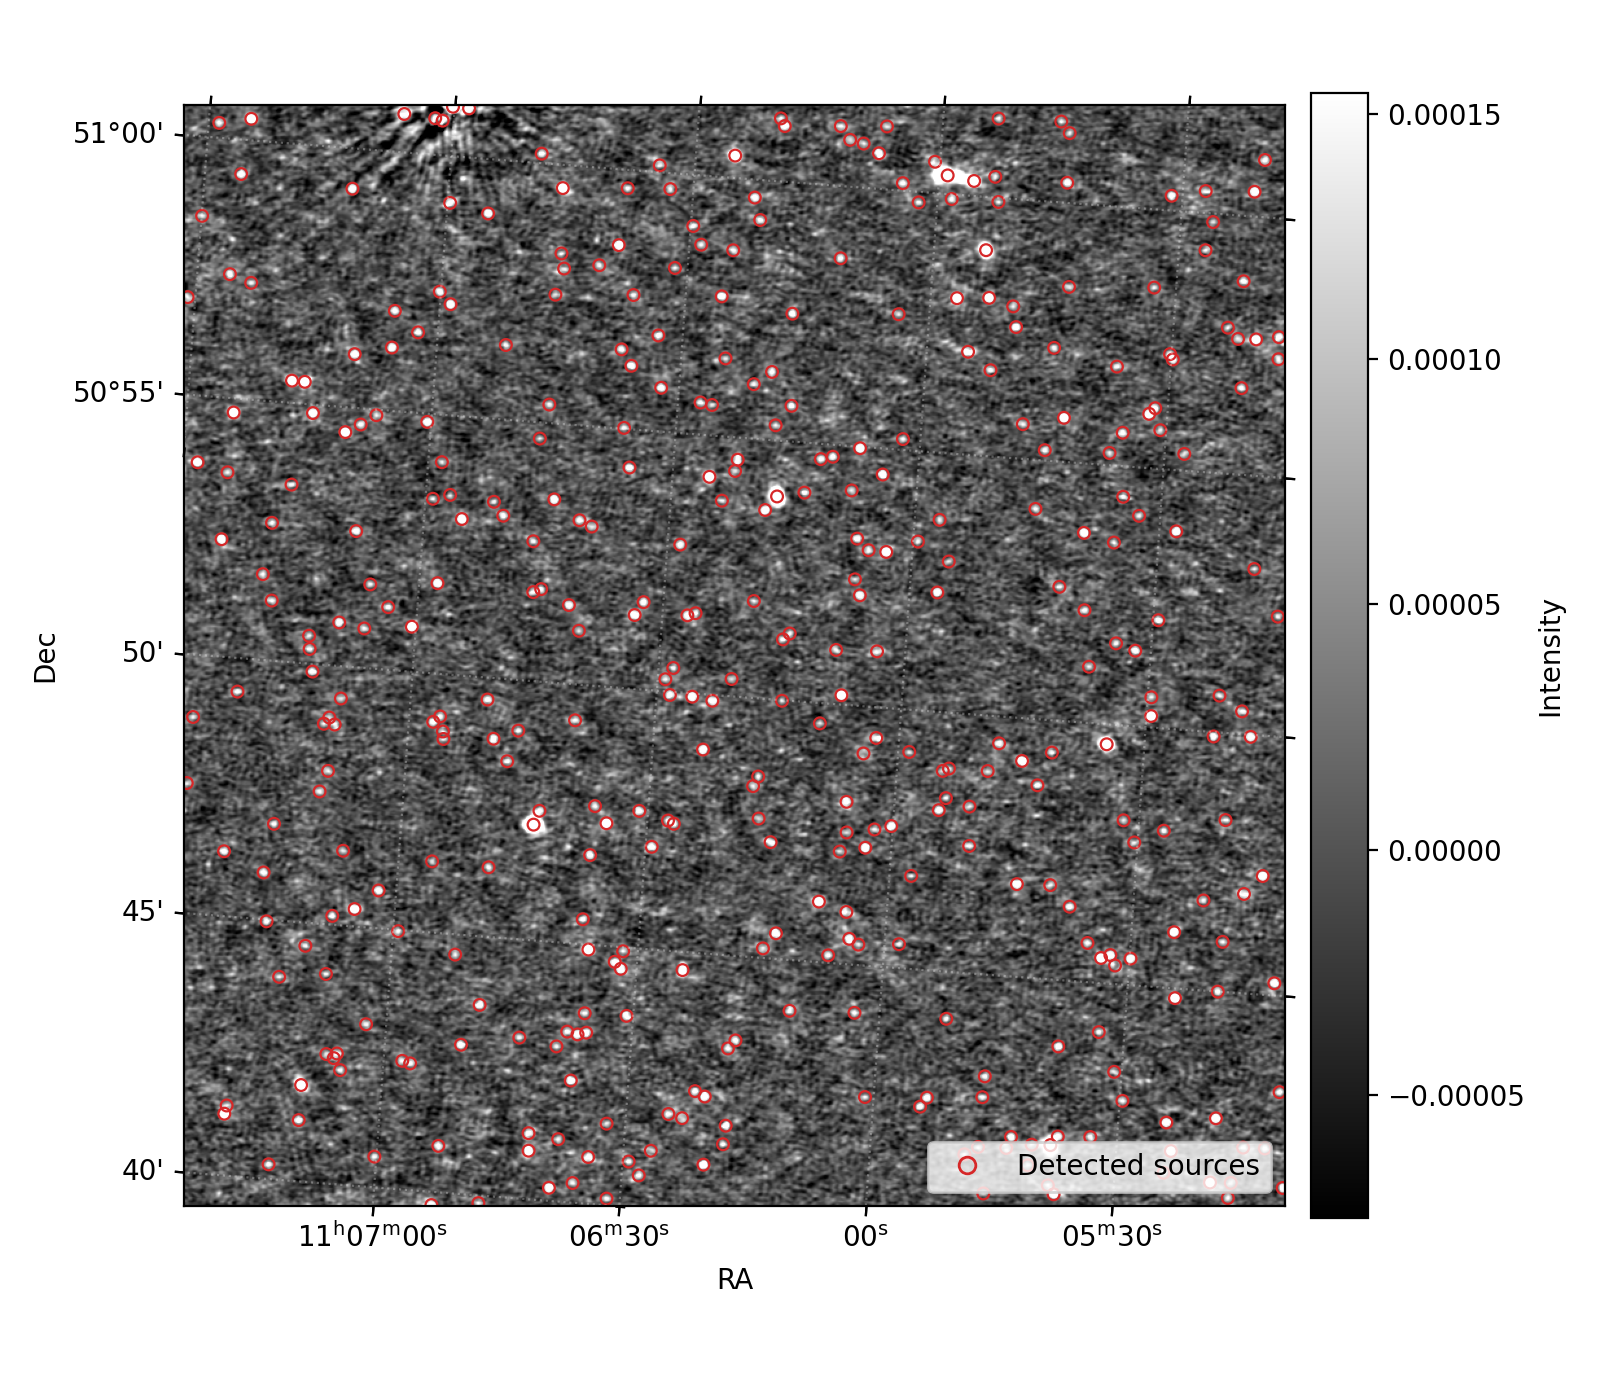

In [8]:
# Create overlay plot showing detected sources
overlay_png = outdir / f"{infile.stem}.overlay.png"

try:
    make_overlay_plot(img2d, hdr2d, srl_fits, overlay_png, label=label_sources)
    print(f"✓ Overlay plot saved: {overlay_png}")
    
    # Display the plot in the notebook
    from IPython.display import Image, display
    display(Image(str(overlay_png)))
    
except Exception as e:
    print(f"WARNING: Overlay plot failed: {e}")
    print("This might be due to missing source data or plotting issues.")


## Optional: Per-Channel Processing for 3D Cubes


In [9]:
# Optional per-channel processing for 3D cubes
if data.ndim == 3 and per_channel_models:
    spec_axis = int(spec_axis) if spec_axis != 'auto' else find_spectral_axis(header)
    nchan = data.shape[spec_axis]
    print(f"Per-channel model/residual export requested: axis={spec_axis}, N={nchan}")
    
    for i in range(nchan):
        slicer = [slice(None)] * 3
        slicer[spec_axis] = i
        plane = data[tuple(slicer)]
        hdr_plane = header.copy()
        
        # Drop spectral axis keywords to make a valid 2D header
        h2 = hdr_plane.copy()
        naxis = h2.get('NAXIS', 0)
        if naxis == 3:
            drop_i = naxis - spec_axis
            keys_to_remove = []
            for key in list(h2.keys()):
                if key.endswith(str(drop_i)):
                    keys_to_remove.append(key)
            for k in keys_to_remove:
                del h2[k]
            h2['NAXIS'] = 2
            for ii in [1, 2]:
                h2[f'NAXIS{ii}'] = plane.shape[1 - (ii - 1)] if ii <= 2 else h2.get(f'NAXIS{ii}', 0)
            for ii in [3, 4, 5, 6, 7, 8, 9]:
                if f'NAXIS{ii}' in h2:
                    del h2[f'NAXIS{ii}']
        
        temp_plane = outdir / f"{infile.stem}.ch{i:04d}.2d.fits"
        fits.writeto(temp_plane, plane.astype(np.float32), h2, overwrite=True)
        
        try:
            run_pybdsf(
                temp_plane,
                outdir,
                thresh_isl=thresh_isl,
                thresh_pix=thresh_pix,
                rms_box=rms_box,
                atrous_do=atrous_do,
                atrous_jmax=atrous_jmax,
                mean_map=mean_map,
                freq_hz=None,
                ncores=ncores,
                write_catalogs=False,
                export_only=['gaus_resid', 'gaus_model'],
            )
            print(f"✓ Per-channel exported model/residual for channel {i}")
        except Exception as e:
            print(f"WARNING: Per-channel export failed at channel {i}: {e}")
else:
    print("Per-channel processing skipped (not a 3D cube or not enabled)")


Per-channel processing skipped (not a 3D cube or not enabled)


## Summary and Output Files


In [10]:
# Display summary of output files
print("=" * 60)
print("PROCESSING COMPLETE")
print("=" * 60)

print(f"\nOutput directory: {outdir}")
print("\nGenerated files:")

# List all files in output directory
output_files = list(outdir.glob("*"))
for file_path in sorted(output_files):
    if file_path.is_file():
        size_mb = file_path.stat().st_size / (1024 * 1024)
        print(f"  {file_path.name:<30} ({size_mb:.2f} MB)")

print(f"\nKey outputs:")
print(f"  • Source catalog (SRL): {srl_fits.name}")
print(f"  • Gaussian catalog (GAUL): {gaul_fits.name}")
print(f"  • Overlay plot: {overlay_png.name}")

# Display source statistics if available
try:
    with fits.open(srl_fits) as hdul:
        sources = hdul[1].data
        n_sources = len(sources)
        print(f"\nSource detection summary:")
        print(f"  • Total sources detected: {n_sources}")
        
        if n_sources > 0:
            # Get flux statistics
            if 'TOTAL_FLUX' in sources.dtype.names:
                total_flux = sources['TOTAL_FLUX']
                print(f"  • Total flux range: {total_flux.min():.3e} - {total_flux.max():.3e}")
            
            if 'PEAK_FLUX' in sources.dtype.names:
                peak_flux = sources['PEAK_FLUX']
                print(f"  • Peak flux range: {peak_flux.min():.3e} - {peak_flux.max():.3e}")
                
except Exception as e:
    print(f"Could not read source statistics: {e}")

print("\n" + "=" * 60)
print("Analysis complete! Check the output files for results.")
print("=" * 60)


PROCESSING COMPLETE

Output directory: pybdsf_out

Generated files:
  test_cut.2d.fits               (2.76 MB)
  test_cut.2d.fits.pybdsf.log    (0.02 MB)
  test_cut.2d.island_mask.fits   (2.76 MB)
  test_cut.2d.model.fits         (2.76 MB)
  test_cut.2d.pybdsf.gaul.fits   (0.16 MB)
  test_cut.2d.pybdsf.srl.fits    (0.15 MB)
  test_cut.2d.residual.fits      (2.76 MB)
  test_cut.2d.rms.fits           (2.76 MB)
  test_cut.overlay.png           (1.37 MB)

Key outputs:
  • Source catalog (SRL): test_cut.2d.pybdsf.srl.fits
  • Gaussian catalog (GAUL): test_cut.2d.pybdsf.gaul.fits
  • Overlay plot: test_cut.overlay.png

Source detection summary:
  • Total sources detected: 397

Analysis complete! Check the output files for results.
